In [7]:
import pandas as pd

sales_df=pd.read_csv("Adidas US Sales Datasets.csv")

In [8]:
sales_df["Invoice Date"] = pd.to_datetime(sales_df["Invoice Date"])
sales_df["year"]=sales_df["Invoice Date"].dt.year
sales_df["month"]=sales_df["Invoice Date"].dt.month
sales_df["short_date"] = sales_df["month"].astype(str) + '/' + sales_df["year"].astype(str)

In [9]:
sales_df.columns

Index(['Retailer', 'Retailer ID', 'Invoice Date', 'Region', 'State', 'City',
       'Product', 'Price per Unit', 'Units Sold', 'Total Sales',
       'Operating Profit', 'Operating Margin', 'Sales Method', 'year', 'month',
       'short_date'],
      dtype='object')

In [10]:
sales_df.loc[sales_df["Units Sold"] == 0, "Units Sold"] = 0.000001 #setting units sold to a very small value to avoid taking log zero

**General Prediction Models**

In [11]:
import pandas as pd

df = pd.read_csv("Adidas US Sales Datasets.csv")
df['Invoice Date']=pd.to_datetime(df["Invoice Date"])
df["Month"] = df["Invoice Date"].dt.month_name()
df['Year']=df["Invoice Date"].dt.year
df=df[['Retailer', 'State','Region','City','Product', 'Sales Method','Month','Year','Units Sold','Price per Unit']]

# Perform one-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['Retailer', 'State', 'City','Product', 'Sales Method','Region','Month','Year'],drop_first=True)

df.head()


,Retailer,State,Region,City,Product,Sales Method,Month,Year,Units Sold,Price per Unit
0,Foot Locker,New York,Northeast,New York,Men's Street Footwear,In-store,January,2020,1200,50
1,Foot Locker,New York,Northeast,New York,Men's Athletic Footwear,In-store,January,2020,1000,50
2,Foot Locker,New York,Northeast,New York,Women's Street Footwear,In-store,January,2020,1000,40
3,Foot Locker,New York,Northeast,New York,Women's Athletic Footwear,In-store,January,2020,850,45
4,Foot Locker,New York,Northeast,New York,Men's Apparel,In-store,January,2020,900,60


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

# Define the features (X) and the target variable (y)
X = df_encoded.drop(columns=['Units Sold'])
y = df_encoded['Units Sold']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a range of values for n_estimators
n_estimators_range = [10, 50, 100, 300,500,1000]

# Create an empty list to store MSE scores for different n_estimators values
mse_scores = []

# Perform cross-validation for each n_estimators value
for n_estimators in n_estimators_range:
    # Create a Random Forest regressor with the chosen n_estimators
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    
    # Perform cross-validation and calculate MSE scores
    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Store the mean MSE score for this n_estimators value
    mse_scores.append(-scores.mean())

# Find the best n_estimators value with the lowest MSE
best_estimators = n_estimators_range[mse_scores.index(min(mse_scores))]

# Train the model with the best n_estimators on the full training set
best_model = RandomForestRegressor(n_estimators=best_estimators, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)

# Evaluate the model's performance on the test set using MSE
mse_test = mean_squared_error(y_test, y_pred_test)

r2_val = r2_score(y_test, y_pred_test)

print(f"Best n_estimators: {best_estimators}")
print(f"Test Set Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Test Set R-squared (R2) Score: {r2_val:.2f}")

Best n_estimators: 1000
Test Set Mean Squared Error (MSE): 11680.00
Test Set R-squared (R2) Score: 0.75


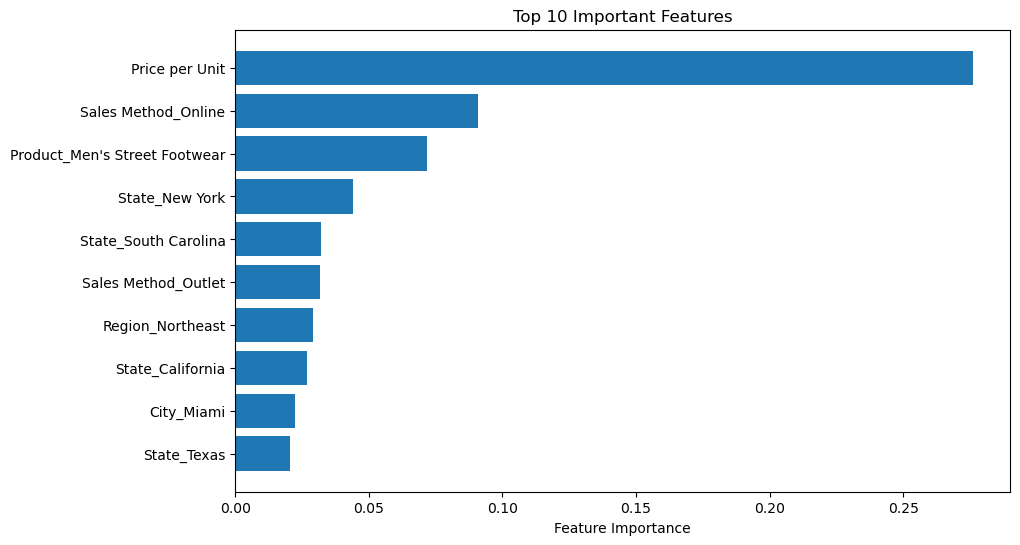

In [13]:
import matplotlib.pyplot as plt

# Get feature importances from the trained Random Forest model
feature_importances = best_model.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N important features (e.g., top 10)
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_importance_df['Feature'][:top_n], sorted_feature_importance_df['Importance'][:top_n])
plt.xlabel('Feature Importance')
plt.title('Top {} Important Features'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

df = pd.read_csv("Adidas US Sales Datasets.csv")
df['Invoice Date']=pd.to_datetime(df["Invoice Date"])
df["Month"] = df["Invoice Date"].dt.month_name()
df['Year']=df["Invoice Date"].dt.year
df=df[['Retailer','State','Region','City','Product', 'Sales Method','Month','Year','Units Sold','Price per Unit']]

# Perform one-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['Retailer', 'Product','City', 'Region','Sales Method','State','Month','Year'],drop_first=True)


# Create a Linear Regression model
mlr_model = LinearRegression()

# Define the features (X) and the target variable (y)
X = df_encoded.drop(columns=['Units Sold'])
y = df_encoded['Units Sold']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.replace({False: 0, True: 1}, inplace=True)
X_test.replace({False: 0, True: 1}, inplace=True)

# Fit the model to your training data
mlr_model.fit(X_train, y_train)

# Assess feature significance using p-values
X_train_with_const = sm.add_constant(X_train)  # Add a constant term (intercept) to the features
mlr_model_sm = sm.OLS(y_train, X_train_with_const).fit()
print(mlr_model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             Units Sold   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     124.6
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:11:56   Log-Likelihood:                -49180.
No. Observations:                7718   AIC:                         9.852e+04
Df Residuals:                    7639   BIC:                         9.907e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [16]:
# Make predictions on the test data
y_pred_test = mlr_model.predict(X_test)

# Evaluate the model's performance on the test data
mse_test = mean_squared_error(y_test, y_pred_test)
r2_val = r2_score(y_test, y_pred_test)

print(f"Test Set Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Test Set R-squared (R2) Score: {r2_val:.2f}")

Test Set Mean Squared Error (MSE): 21293.26
Test Set R-squared (R2) Score: 0.55


In [17]:
# Get the summary table as a DataFrame
summary_df = pd.read_html(mlr_model_sm.summary().tables[1].as_html(), header=0, index_col=0)[0]

# Filter out significant variables (p-value < 0.05)
significant_vars = summary_df[summary_df['P>|t|'] < 0.05]

# Sort the significant variables by the absolute value of coefficients (high to low)
sorted_significant_vars = significant_vars.reindex(
    significant_vars['coef'].abs().sort_values(ascending=False).index
)

# Print the sorted significant variables
sorted_significant_vars.head(10)

,coef,std err,t,P>|t|,[0.025,0.975]
Sales Method_Online,-270.8503,5.144,-52.649,0.0,-280.935,-260.766
Product_Men's Street Footwear,211.7188,5.708,37.092,0.0,200.530,222.908
State_South Carolina,169.3762,8.606,19.681,0.0,152.506,186.246
Sales Method_Outlet,-152.0331,6.173,-24.627,0.0,-164.135,-139.932
State_New York,143.8942,13.321,10.802,0.0,117.781,170.007
City_Orlando,-139.1214,12.735,-10.925,0.0,-164.085,-114.158
City_New York,124.7404,29.730,4.196,0.0,66.461,183.020
Product_Men's Athletic Footwear,118.1340,5.759,20.515,0.0,106.846,129.422
Product_Women's Street Footwear,109.9334,5.916,18.583,0.0,98.337,121.530
City_Columbus,99.0766,8.160,12.142,0.0,83.081,115.073


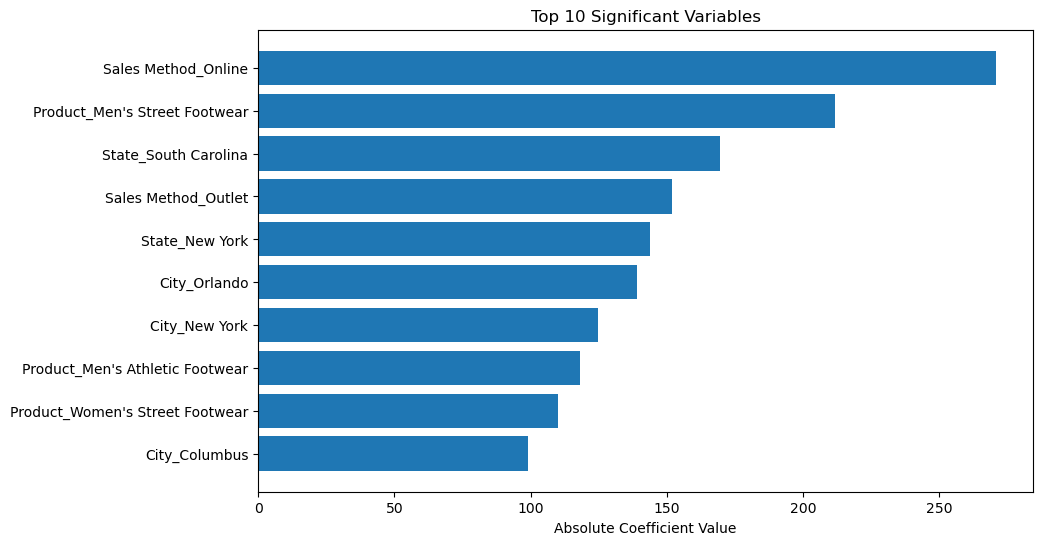

In [18]:
# Select the top N significant variables (e.g., top 10)
top_n = 10
top_significant_vars = sorted_significant_vars.head(top_n)

# Plot the top N significant variables
plt.figure(figsize=(10, 6))
plt.barh(top_significant_vars.index, top_significant_vars['coef'].abs())
plt.xlabel('Absolute Coefficient Value')
plt.title('Top {} Significant Variables'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to show the most significant variables at the top
plt.show()

**Elasticity of Units Sold with respect to Price per Unit -- For Offline Sales Channel**

In [19]:
sales_df=sales_df.sort_values(by=["year","month"],ascending=True)

import numpy as np
import statsmodels.api as sm

dummy_df = pd.get_dummies(sales_df, columns=['Region', 'State', 'Retailer', 'City'])

short_dates = dummy_df["short_date"].unique()

offline_df = pd.DataFrame(columns=['Short Date', 'Coefficient',"P-value"])

for short_date in short_dates:
    month, year = map(int, short_date.split('/'))
    
    test11 = dummy_df[(dummy_df["year"] == year) & (dummy_df["month"] == month) & 
                      (dummy_df["Sales Method"] != "Online")].copy(deep=True)

    X = np.log(test11[["Price per Unit"]])
    y = np.log(test11["Units Sold"])

    X = sm.add_constant(X)
    linMod = sm.OLS(y,X).fit()
    if linMod.pvalues[1]<0.05:
        offline_df = pd.concat([offline_df, pd.DataFrame({'Short Date': [short_date], 'Coefficient': [linMod.params[1]],'P-value': [round(linMod.pvalues[1],3)]})], ignore_index=True)

In [20]:
offline_df

,Short Date,Coefficient,P-value
0,1/2020,0.912492,0.005
1,2/2020,1.207269,0.000
2,3/2020,1.198891,0.000
3,5/2020,0.688833,0.037
4,7/2020,0.402736,0.001
5,8/2020,1.083787,0.000
6,9/2020,1.994116,0.000
7,10/2020,2.132513,0.000
8,11/2020,1.781745,0.002
9,12/2020,1.656437,0.000


**Elasticity of Units Sold with respect to Price per Unit only -- For Online Sales Channel**

In [21]:
sales_df=sales_df.sort_values(by=["year","month"],ascending=True)
dummy_df = pd.get_dummies(sales_df, columns=['Region', 'State','Retailer','City','Product'])
dummy_df

import numpy as np
import statsmodels.api as sm

dummy_df = pd.get_dummies(sales_df, columns=['Region', 'State', 'Retailer', 'City'])

short_dates = dummy_df["short_date"].unique()

online_df = pd.DataFrame(columns=['Short Date', 'Coefficient'])

for short_date in short_dates:
    month, year = map(int, short_date.split('/'))
    
    test11 = dummy_df[(dummy_df["year"] == year) & (dummy_df["month"] == month) & 
                      (dummy_df["Sales Method"] == "Online")].copy(deep=True)

    X = np.log(test11[["Price per Unit"]])
    y = np.log(test11["Units Sold"])

    X = sm.add_constant(X)
    linMod = sm.OLS(y,X).fit()
    if linMod.pvalues[1]<0.05:
        online_df = pd.concat([online_df, pd.DataFrame({'Short Date': [short_date], 'Coefficient': [linMod.params[1]],'P-value': [round(linMod.pvalues[1],3)]})], ignore_index=True)

In [22]:
online_df

,Short Date,Coefficient,P-value
0,1/2020,-0.976963,0.012
1,2/2020,-1.131271,0.001
2,4/2020,-0.771454,0.027
3,7/2020,-0.313413,0.003
4,8/2020,-0.404633,0.001
5,9/2020,0.499646,0.004
6,10/2020,2.256307,0.000
7,11/2020,2.738929,0.000
8,12/2020,1.860503,0.000
9,5/2021,0.672832,0.000


**Visualization - Price Elasticities by Sales Channel**

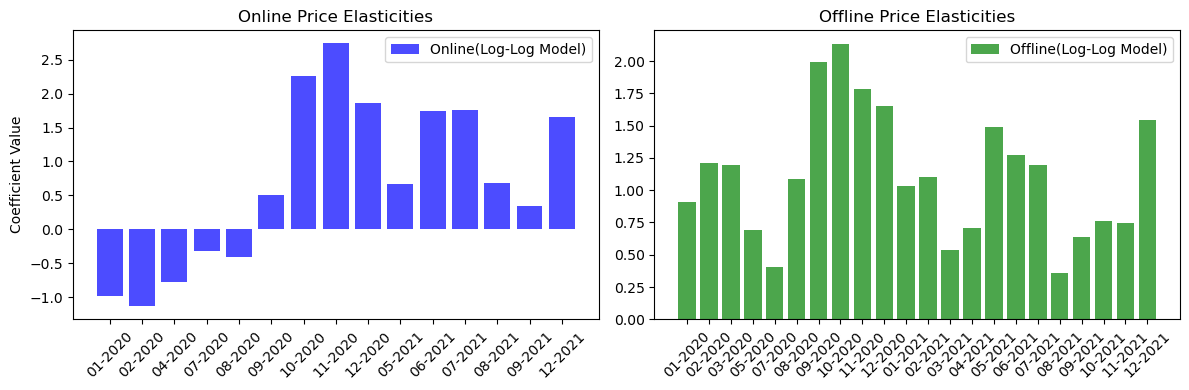

In [23]:
import matplotlib.pyplot as plt
import numpy as np

online_df['Short Date'] = pd.to_datetime(online_df['Short Date'], format='%m/%Y')
online_df = online_df.sort_values(by=['Short Date'])

offline_df['Short Date'] = pd.to_datetime(offline_df['Short Date'], format='%m/%Y')
offline_df = offline_df.sort_values(by=['Short Date'])


x_online = np.arange(len(online_df['Short Date']))
x_offline = np.arange(len(offline_df['Short Date']))


bar_width = 0.35


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#online_df as the first subplot
axs[0].bar(x_online, online_df['Coefficient'], color='blue', alpha=0.7, label='Online(Log-Log Model)')
axs[0].set_ylabel('Coefficient Value')
axs[0].set_title('Online Price Elasticities')
axs[0].set_xticks(x_online)
axs[0].set_xticklabels(online_df['Short Date'].dt.strftime('%m-%Y'), rotation=45)
axs[0].legend()
axs[0].grid(False)

#offline_df as the first subplot
axs[1].bar(x_offline, offline_df['Coefficient'], color='green', alpha=0.7, label='Offline(Log-Log Model)')
axs[1].set_title('Offline Price Elasticities')
axs[1].set_xticks(x_offline)
axs[1].set_xticklabels(offline_df['Short Date'].dt.strftime('%m-%Y'), rotation=45)
axs[1].legend()
axs[1].grid(False)
plt.tight_layout()
plt.show()



**Month-level elasticity modelling for Women's product categories**

In [24]:
sales_df=sales_df.sort_values(by=["year","month"],ascending=True)
dummy_df = pd.get_dummies(sales_df, columns=['Region', 'State','Retailer','City'])
dummy_df

import numpy as np
import statsmodels.api as sm

dummy_df = pd.get_dummies(sales_df, columns=['Region', 'State', 'Retailer', 'City'])

short_dates = dummy_df["short_date"].unique()

women_df = pd.DataFrame(columns=['Short Date', 'Coefficient'])

for short_date in short_dates:
    month, year = map(int, short_date.split('/'))
    
    test11 = dummy_df[(dummy_df["year"] == year) & (dummy_df["month"] == month) & 
                      (dummy_df["Sales Method"] == "Online")& dummy_df["Product"].isin(["Women's Apparel", "Women's Athletic Footwear", "Women's Street Footwear"])].copy(deep=True)

    X = np.log(test11[["Price per Unit"]])
    y = np.log(test11["Units Sold"])

    X = sm.add_constant(X)
    linMod = sm.OLS(y,X).fit()
    if linMod.pvalues[1]<0.05:
        women_df = pd.concat([women_df, pd.DataFrame({'Short Date': [short_date], 'Coefficient': [linMod.params[1]],'P-value': [round(linMod.pvalues[1],3)]})], ignore_index=True)

In [25]:
women_df

,Short Date,Coefficient,P-value
0,1/2020,-1.082808,0.009
1,2/2020,-1.047061,0.003
2,8/2020,-0.398572,0.011
3,10/2020,2.431757,0.000
4,11/2020,3.588027,0.000
5,12/2020,1.926229,0.000
6,4/2021,0.324101,0.017
7,5/2021,1.049252,0.000
8,6/2021,2.184339,0.000
9,7/2021,1.649234,0.000


**Month-level elasticity modelling for Men's product categories**

In [26]:
sales_df=sales_df.sort_values(by=["year","month"],ascending=True)

import numpy as np
import statsmodels.api as sm

dummy_df = pd.get_dummies(sales_df, columns=['State', 'Retailer', 'City'])

short_dates = dummy_df["short_date"].unique()

men_df = pd.DataFrame(columns=['Short Date', 'Coefficient'])

for short_date in short_dates:
    month, year = map(int, short_date.split('/'))
    
    test11 = dummy_df[(dummy_df["year"] == year) & (dummy_df["month"] == month) & 
                      (dummy_df["Sales Method"] == "Online")& dummy_df["Product"].isin(["Men's Apparel", "Men's Athletic Footwear", "Men's Street Footwear"])].copy(deep=True)

    X = np.log(test11[["Price per Unit"]])
    y = np.log(test11["Units Sold"])

    X = sm.add_constant(X)
    linMod = sm.OLS(y,X).fit()
    if linMod.pvalues[1]<0.05:
        men_df = pd.concat([men_df, pd.DataFrame({'Short Date': [short_date], 'Coefficient': [linMod.params[1]],'P-value': [round(linMod.pvalues[1],3)]})], ignore_index=True)

In [27]:
men_df

,Short Date,Coefficient,P-value
0,2/2020,-1.821625,0.022
1,4/2020,-1.461517,0.038
2,7/2020,-0.286862,0.038
3,8/2020,-0.445565,0.020
4,9/2020,0.744473,0.009
5,10/2020,1.827369,0.046
6,12/2020,1.670457,0.024
7,2/2021,-0.556987,0.033
8,3/2021,-0.637915,0.002
9,4/2021,-0.559409,0.005


**Visulization - Price Elasticities by Product Type**

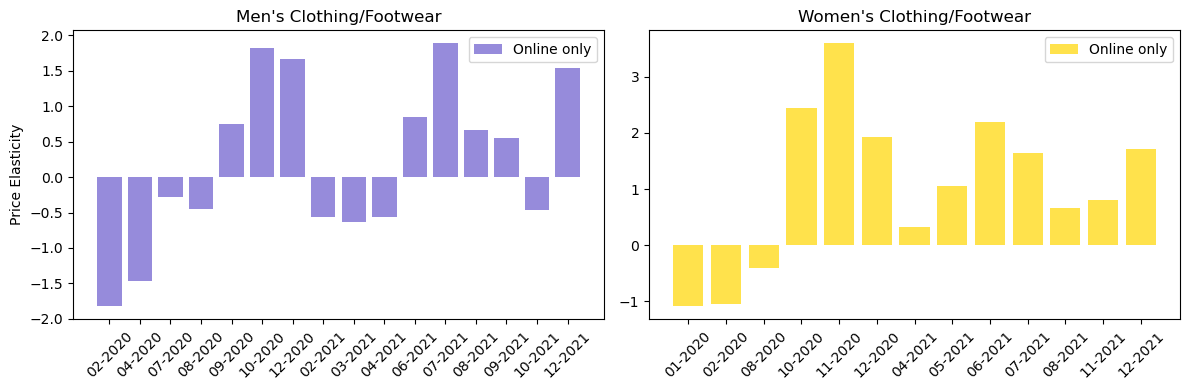

In [28]:
import matplotlib.pyplot as plt
import numpy as np

men_df['Short Date'] = pd.to_datetime(men_df['Short Date'], format='%m/%Y')
men_df = men_df.sort_values(by=['Short Date'])

women_df['Short Date'] = pd.to_datetime(women_df['Short Date'], format='%m/%Y')
women_df = women_df.sort_values(by=['Short Date'])

x_men = np.arange(len(men_df['Short Date']))
x_women = np.arange(len(women_df['Short Date']))

bar_width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].bar(x_men, men_df['Coefficient'], color='#6A5ACD', alpha=0.7, label='Online only')
axs[0].set_ylabel('Price Elasticity')
axs[0].set_title("Men's Clothing/Footwear")
axs[0].set_xticks(x_men)
axs[0].set_xticklabels(men_df['Short Date'].dt.strftime('%m-%Y'), rotation=45)
axs[0].grid(False)
axs[0].legend()

axs[1].bar(x_women, women_df['Coefficient'], color='#FFD700', alpha=0.7, label='Online only')
axs[1].set_title("Women's Clothing/Footwear")
axs[1].set_xticks(x_women)
axs[1].set_xticklabels(women_df['Short Date'].dt.strftime('%m-%Y'), rotation=45)
axs[1].legend()
axs[1].grid(False)


plt.tight_layout()
plt.show()


**Regional, month-level price elasticities for men's products**

In [29]:
#regional, month-level price elasticities for men's products
men_region_df = pd.DataFrame(columns=['Region', 'Short Date', 'Coefficient', 'P-value'])

for short_date in short_dates:
    month, year = map(int, short_date.split('/'))
    
    for region in dummy_df["Region"].unique():
        test11 = dummy_df[(dummy_df["year"] == year) & (dummy_df["month"] == month) & 
                          (dummy_df["Sales Method"] == "Online") & 
                          (dummy_df["Product"].isin(["Men's Apparel", "Men's Athletic Footwear", "Men's Street Footwear"])) & 
                          (dummy_df["Region"] == region)].copy(deep=True)
                          
        if test11.shape[0] > 0:
            X = np.log(test11[["Price per Unit"]])
            y = np.log(test11["Units Sold"])

            X = sm.add_constant(X)
            linMod = sm.OLS(y,X).fit()
            
            if linMod.pvalues[1] < 0.05:
                men_region_df = pd.concat([men_region_df, 
                                        pd.DataFrame({'Region': [region], 
                                                      'Short Date': [short_date], 
                                                      'Coefficient': [linMod.params[1]], 
                                                      'P-value': [round(linMod.pvalues[1], 3)]})], ignore_index=True)
men_region_df['Short Date'] = pd.to_datetime(men_region_df['Short Date'], format='%m/%Y')

In [30]:
men_region_df.sort_values(by=["Region","Short Date"])

,Region,Short Date,Coefficient,P-value
6,Midwest,2021-07-01,2.577985,0.000
9,Midwest,2021-09-01,2.104416,0.000
10,Midwest,2021-12-01,1.968183,0.002
4,Northeast,2021-05-01,1.886636,0.010
5,Northeast,2021-07-01,1.918625,0.003
7,Northeast,2021-08-01,1.772493,0.047
2,South,2021-03-01,-1.061162,0.009
8,South,2021-08-01,0.649966,0.002
1,Southeast,2021-03-01,-2.458267,0.002
3,Southeast,2021-04-01,-1.786037,0.012


**Visualization - Price Elasticities of Men's Products by Region**

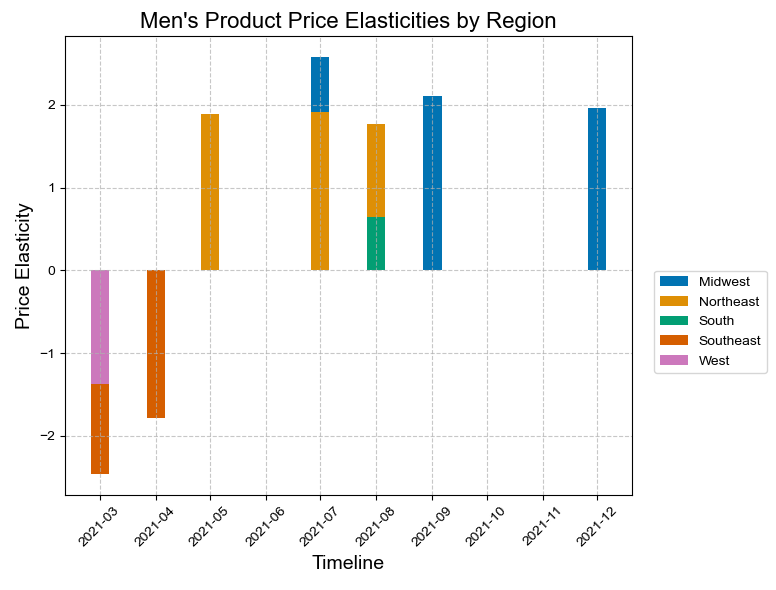

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

men_region_df['Short Date'] = pd.to_datetime(men_region_df['Short Date'], format='%m/%Y')


men_region_df = men_region_df.sort_values(by=['Short Date', 'Region'])

grouped = men_region_df.groupby('Region')

plt.figure(figsize=(8, 6))

for region, group in grouped:
    plt.bar(group['Short Date'], group['Coefficient'], width=10, label=region, align='center')

plt.xlabel('Timeline', fontsize=14)
plt.ylabel('Price Elasticity', fontsize=14)
plt.title("Men's Product Price Elasticities by Region", fontsize=16)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.25))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

sns.set_style("whitegrid")

plt.show()

**Regional, month-level price elasticities for women's products**

In [32]:
#regional, month-level price elasticities for women's products
women_region_df = pd.DataFrame(columns=['Region', 'Short Date', 'Coefficient', 'P-value'])

for short_date in short_dates:
    month, year = map(int, short_date.split('/'))
    
    for region in dummy_df["Region"].unique():
        test11 = dummy_df[(dummy_df["year"] == year) & (dummy_df["month"] == month) & 
                          (dummy_df["Sales Method"] == "Online") & 
                          (dummy_df["Product"].isin(["Women's Apparel", "Women's Athletic Footwear", "Women's Street Footwear"])) & 
                          (dummy_df["Region"] == region)].copy(deep=True)
                          
        if test11.shape[0] > 0:
            X = np.log(test11[["Price per Unit"]])
            y = np.log(test11["Units Sold"])

            X = sm.add_constant(X)
            linMod = sm.OLS(y,X).fit()
            
            if linMod.pvalues[1] < 0.05:
                women_region_df = pd.concat([women_region_df, 
                                        pd.DataFrame({'Region': [region], 
                                                      'Short Date': [short_date], 
                                                      'Coefficient': [linMod.params[1]], 
                                                      'P-value': [round(linMod.pvalues[1], 3)]})], ignore_index=True)

In [33]:
women_region_df.sort_values(["Region","Short Date"])

,Region,Short Date,Coefficient,P-value
7,Midwest,11/2020,2.199635,0.031
28,Midwest,11/2021,0.766473,0.018
8,Midwest,12/2020,1.183458,0.008
31,Midwest,12/2021,1.787620,0.001
16,Midwest,5/2021,1.727118,0.003
20,Midwest,6/2021,3.018643,0.030
22,Midwest,7/2021,2.133122,0.000
26,Northeast,10/2021,0.694666,0.036
27,Northeast,11/2021,1.171962,0.000
29,Northeast,12/2021,1.411347,0.000


**Visualization - Price Elasticities of Women's Products by Region**

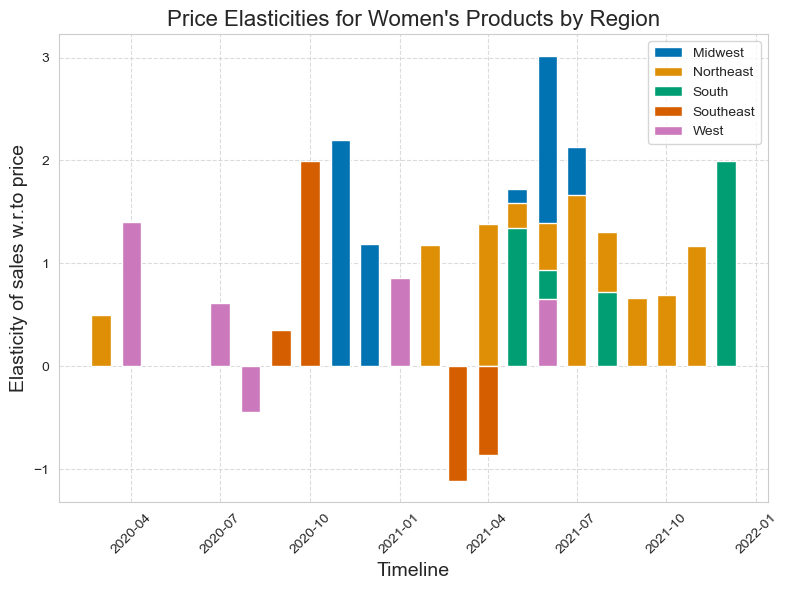

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

women_region_df['Short Date'] = pd.to_datetime(women_region_df['Short Date'], format='%m/%Y')


women_region_df = women_region_df.sort_values(by=['Short Date', 'Region'])

grouped = women_region_df.groupby('Region')

plt.figure(figsize=(8, 6))

for region, group in grouped:
    plt.bar(group['Short Date'], group['Coefficient'], width=20, label=region, align='center')

plt.xlabel('Timeline', fontsize=14)
plt.ylabel('Elasticity of sales w.r.to price', fontsize=14)
plt.title("Price Elasticities for Women's Products by Region", fontsize=16)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

sns.set_style("whitegrid")

plt.show()

**Visulization - Product Price Elasticities by Region - Comparison Plots**

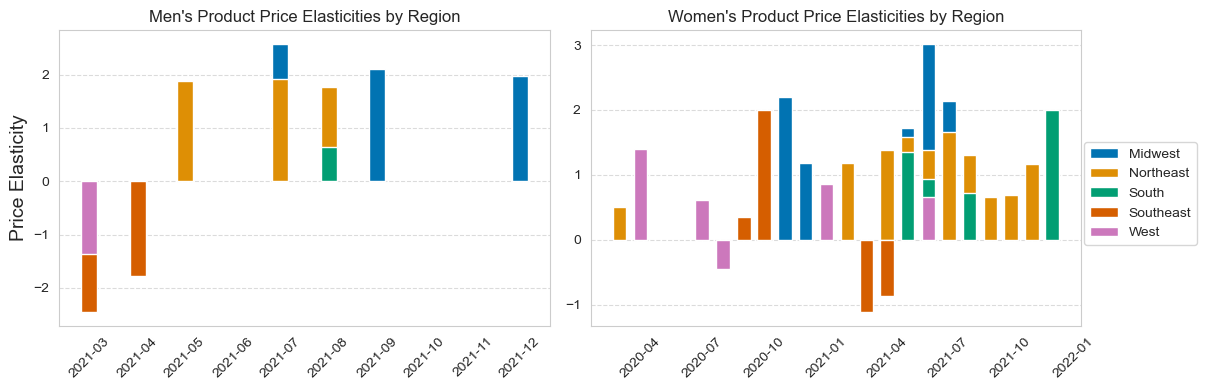

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#men's product price elasticities by region
grouped_men = men_region_df.groupby('Region')
axs[0].set_title("Men's Product Price Elasticities by Region")
for region, group in grouped_men:
    axs[0].bar(group['Short Date'], group['Coefficient'], width=10, label=region, align='center')
axs[0].set_ylabel('Price Elasticity', fontsize=14)
axs[0].grid(True, axis='y', linestyle='--', alpha=0.7)
axs[0].tick_params(axis='x', rotation=45)
axs[0].xaxis.grid(False)

#women's product price elasticities by region
grouped_women = women_region_df.groupby('Region')
axs[1].set_title("Women's Product Price Elasticities by Region")
for region, group in grouped_women:
    axs[1].bar(group['Short Date'], group['Coefficient'], width=20, label=region, align='center')
axs[1].legend(loc='lower right', bbox_to_anchor=(1.25,0.25))
axs[1].grid(True, axis='y', linestyle='--', alpha=0.7)
axs[1].tick_params(axis='x', rotation=45)
axs[1].xaxis.grid(False)

plt.tight_layout()
sns.set_style("whitegrid")

plt.show()
